In [2]:
from itertools import chain
from functools import partial

import scipy
from scipy import stats
from scipy.optimize import fmin
from scipy.stats import norm
from scipy.stats import beta
from scipy.special import gamma as gammaf

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import random
from numpy.random import choice
import time
import re

sns.set(color_codes=True)
from math import exp, log

# Fitter bâton bêta
On découpe aléatoirement un génome en N fragments et on récupère la taille des fragments obtenus.
On cherche à vérifier que la distribution de la taille de ces fragments suit une loi bêta(1,N).

In [3]:
def get_parts(longueur, nbr_frag):
    """
    découpe aléatoirement un génome 
    <longueur>: longueur du génome à découper
    <nbr_frag>: nombre de fragments souhaités
    Return <nll>: liste de taille des fragments obtenus
    """
    cuts = set()
    while len(cuts) < nbr_frag - 1:
        cuts.add(random.randint(1, longueur - 1))
    cuts = [0] + list(sorted(cuts)) + [longueur]
    return [cuts[i + 1] - cuts[i] for i in range(len(cuts) - 1)]

On affiche l'histogramme de la distribution des tailles desfragments. 

Ici on a coupé un génome de taille 1 000 000 en N = 60 000 morceaux.

On affiche également la densité de la loi bêta de paramètres : 1,N

(array([3.7735e+04, 1.3994e+04, 5.2250e+03, 1.8700e+03, 7.1000e+02,
        3.1000e+02, 9.5000e+01, 4.4000e+01, 1.0000e+01, 7.0000e+00]),
 array([  1.,  17.,  33.,  49.,  65.,  81.,  97., 113., 129., 145., 161.]),
 <a list of 10 Patch objects>)

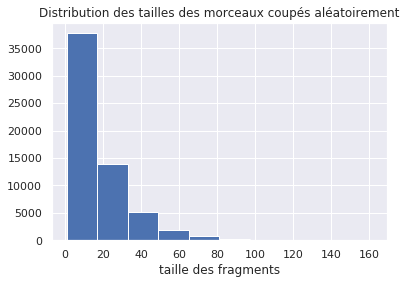

In [4]:
taille = get_parts(1000000, 60000)
plt.title("Distribution des tailles des morceaux coupés aléatoirement")
plt.xlabel("taille des fragments")
plt.hist(taille)


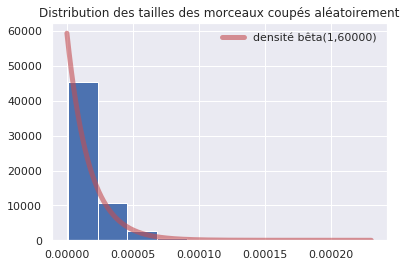

In [5]:
a=1
b=60000

taille = get_parts(1000000, 60000)

t = sum(taille)

taille = [i / t for i in taille] #normalise les tailles pour qu'elles soient comprises entre 0 et 1

x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.999999, a, b), 60000)
plt.plot(x, beta.pdf(x, a, b),'r-', lw=5, alpha=0.6, label='densité bêta(1,60000)')
plt.hist(taille)
plt.legend(loc='best', frameon=False)
plt.title("Distribution des tailles des morceaux coupés aléatoirement")
plt.show()

On remarque que la courbe de la densité de la loi bêta(1,60000) a la même allure que la distribution des tailles.

## Méthodes moments

Nous allons ensuite "fitter" cette distribution en utilisant la méthode des moments et celle du maximum de vraisemblance afin d'estimer les paramètres de la loi bêta.

Soit la moyenne empirique : $m$ = $ \frac{1}{n} $$\sum_{i=1}^{n} x_{i}$ 

et la variance : $v$ = $ \frac{1}{n} $$\sum_{i=1}^{n} (x_{i}-m)$

D'après la méthode des moments on estime les paramètres de la loi bêta($\alpha$, $\beta$) 

$\alpha$ = $m$($ \frac{m(1-m)}{v}$$ - 1)$

$\beta$ = $(1-m)$($ \frac{m(1-m)}{v}$$-1)$


In [4]:
mean = np.mean(taille)
var = np.var(taille, ddof=1)

alpha1 = mean ** 2 * (1 - mean) / var - mean
beta1 = alpha1 * (1 - mean) / mean

print("Les paramètres estimés par la méthode des moments sont : alpha = ", alpha1, ", beta = ",beta1)


Les paramètres estimés par la méthode des moments sont : alpha =  1.0755860845764211 , beta =  64534.08948850069


## Vraisemblance

En utilisant la méthode du maximum de vraisemblance : 
 
 $l($$\alpha$, $\beta$$)$ $=$ $\sum_{i=1}^{n} $$-$log$f_{(\alpha, \beta)}(x_{i})$
 
 où $f_{(\alpha, \beta)}$ : la fonction densité de la loi bêta($\alpha$, $\beta$)
 
 L'estimateur du maximum de vraisemblance de $\alpha$ et $\beta$ est donné par :
 
 $(\hat{\alpha}, \hat{\beta})$ = $\underset{\alpha>0, \beta>0 }{argmin}$ $l($$\alpha$, $\beta$$)$

In [5]:
def betaNLL(param, *args):
    """
    log négative vraisemblance pour bêta
    <param>: liste des paramètres à "fitter"
    <args>: données à "fitter"
    Return <nll>: log négative vraisemblance à minimiser
    """  
    a, b = param
    data = args[0]
    pdf = beta.pdf(data,a,b,loc=0,scale=1)
    lg = np.log(pdf)
    nll = -1*np.sum(lg)
    return nll

In [6]:
result = fmin(betaNLL, [1, 1], args=(taille,))
alpha2, beta2 = result

print("Les paramètres estimés par la méthode de la vraisemblance sont : \nalpha = ", alpha2, ", beta = ",beta2)


Optimization terminated successfully.
         Current function value: -600643.241549
         Iterations: 128
         Function evaluations: 256
Les paramètres estimés par la méthode de la vraisemblance sont : 
alpha =  1.18504698795277 , beta =  71101.1087590054


On affiche ensuite les densités des lois bêta dont les paramètres ont été trouvés précedemment.

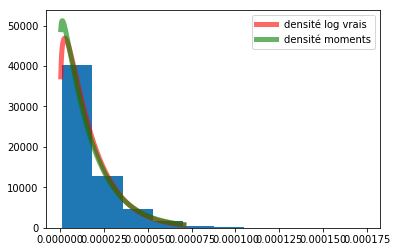

In [7]:
xx = np.linspace(beta.ppf(0.01, alpha2, beta2), beta.ppf(0.99, alpha2, beta2), 60000)
plt.plot(xx, beta.pdf(xx, alpha2, beta2),'r-', lw=5, alpha=0.6, label='densité log vrais')
plt.plot(xx, beta.pdf(xx, alpha1, beta1),'g-', lw=5, alpha=0.6, label='densité moments')
plt.legend()
plt.hist(taille)
plt.show()

# Fitter données expérimentales

In [42]:
def f(x, g, n):
    """
    fonction loi beta qui correspond à la distribution théorique de la taille des reads
    :param x: taille des reads
    :param g: taille du génome
    :param n: nombre de fragments
    :return: fonction loi beta
    """
    return  n* (1 - x/g) ** (n - 1)

On trace cette fonction pour un génome de taille 1000000 et de nombre de fragments 60 000.

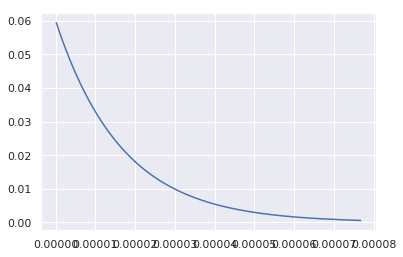

In [24]:
a=1
b=60000

x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 1000)
plt.plot(x, f(x,1000000,b))

In [110]:
monFichier = open("../Documents/Donnees/DRR164914.fastq", "r") #MINION
taille = []
f = []
norm = []

for line in monFichier:
    fields = line.strip().split()
    for idx, word in enumerate(fields):
        f.append(word)

for i, element in enumerate(f):
    if element.endswith("/1") and i + 1 < len(f):
        taille.append(len(f[i + 1]))

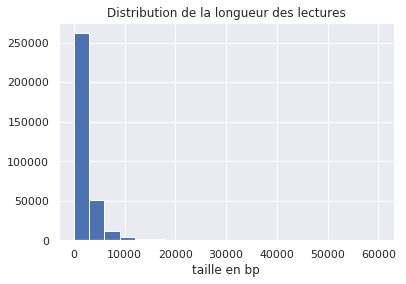

In [112]:
m=max(taille)
plt.hist(taille, range = (0,60000),bins=20)
plt.title("Distribution de la longueur des lectures")
plt.xlabel("taille en bp")
plt.show()


172138


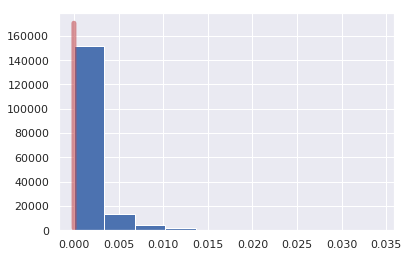

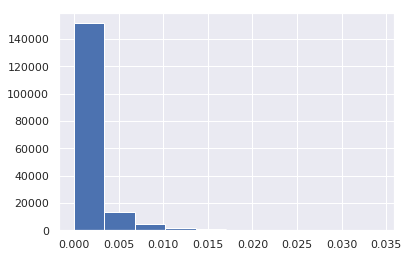

In [63]:
t = sum(taille)
maxi = max(taille)
a=1
b=len(taille)
print(b)
g = 3711100
norm = [i / g for i in taille]

x = np.linspace(beta.ppf(0.01, a, b), beta.ppf(0.99, a, b), 10000)

plt.plot(x, beta.pdf(x, a, b),'r-', lw=5, alpha=0.6, label='densité bêta(1,60000)')
plt.hist(norm)
plt.show()

xx = np.linspace(0, 80000)
weights = np.ones_like(taille) / float(len(taille))
#print(f(xx,g,b)) #tester fonction pour déterminer la taille du génome #problème
#plt.plot(xx, f(xx,g,b), 'g')
plt.hist(norm)

plt.show()


# Simulation séquençage

On écrit un programme permettant de découper un génome en N morceaux où N suit soit une loi normale, uniforme ou de poisson.

On trace cette fonction pour un génome de taille 1000000 et de nombre de fragments 60 000.

In [6]:
lois = ['normale', 'uniforme', 'poisson']

def fracture(echantillons, loi='normale', parametres=None):
    """
    Fracture une liste d'échantillons en utilisant un nombre de fractures variables de loi n = Norm(N, sigma)
    :param sigma:
    :param n: Ecart-type
    :param echantillons:
    :return:
    """
    if loi == 'normale':
        n, sigma = parametres
        nfrag = n + np.random.randn(len(echantillons)) * sigma
        
    elif loi == 'uniforme':
        nmin, nmax = parametres
        nfrag = np.random.uniform(nmin, nmax, len(echantillons))

    elif loi == 'poisson':
        n = parametres
        nfrag = np.random.poisson(n, len(echantillons))
        
    else:
        raise NotImplementedError(loi)
    échantillons_fracturés = []
    échantillon_fracture = []

    # On prends chaque échantillon et lui associe un nombre de fractures, converti en int à la volée
    for index, (nombre_fragments, taille_échantillon) in enumerate(zip(map(int, nfrag), echantillons)):

        if nombre_fragments > taille_échantillon:
            raise ValueError(
                '\n\n\n'
                'ERREUR: Le nombre de fragments demandé est trop grand, il est impossible de continuer\n'
                'Vous pouvez: \n'
                '\t- Réduire le nombre de fragments demandé, en jouant sur N et sigma\n'
                '\t- Augmenter la taille des échantillons à fracturer\n'
            )
        # Il y aura n - 1 fractures pour obtenir n elements
        nombre_fractures = nombre_fragments - 1

        # Une fracture sera placée avant l'index désigné, donc une fracture
        #   localisée à l'index 1 donnera un morceau de 1 et un de taille - 1
        fractures = set()
        while len(fractures) < nombre_fractures:
            fractures.update(np.random.randint(1, taille_échantillon - 1, nombre_fractures))
        if len(fractures) != nombre_fractures:
            if len(fractures) < nombre_fractures:
                raise RuntimeError('ERREUR: Une erreur s\'est produite: pas assez de fragments')
            fractures = set(list(fractures)[:nombre_fractures])
            
        fractures = list(fractures)
        
        fractures = [0] + list(sorted(fractures)) + [taille_échantillon]
        échantillon_fracturé = [
            fractures[i + 1] - fractures[i] for i in range(len(fractures) - 1)
        ]
        if sum(échantillon_fracturé) != taille_échantillon:
            raise RuntimeError(
                "ERREUR: Une erreur s'est produite lors de la fragmentation, \n"
                f"Nous avons {abs(sum(échantillon_fracturé) - taille_échantillon)}"
                f" fragments de différence entre ce qu'on attendais et ce qu'on a"
                f" ({sum(échantillon_fracturé)} contre {taille_échantillon})"
            )
        échantillon_fracturé = list(i for i in sorted(échantillon_fracturé))
        échantillons_fracturés.append(échantillon_fracturé)
        
    return échantillons_fracturés

In [110]:
def choices(array, weights, k):
    """
    fonction comme random choice sans remplacement
    """
    assert len(array) > k
    index, cumulated = 0, []
    for w in weights:
        cumulated.append(index)
        index += w
    choi = set()
    while len(choi) < k:
        i = random.random() * index
        j = next(y for y, x in reversed(list(enumerate(cumulated))) if i > x)
        choi.add(j)
    return [array[k] for k in choi]

### MINION
On tire N morceaux tel que les petit morceaux aient plus de chance d'être tirés grâce à la fonction random.choice  

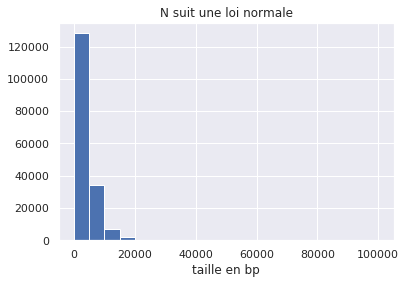

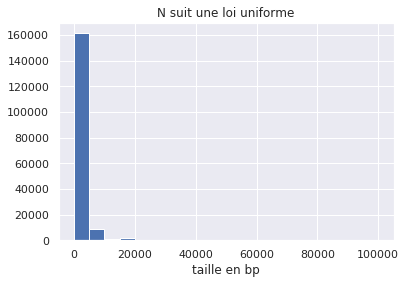

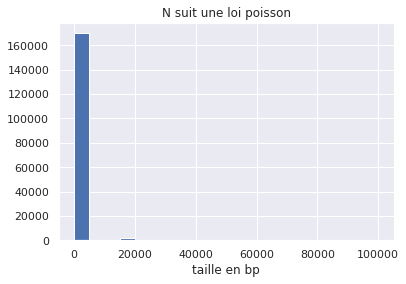

In [114]:
taille_genome =3711100


def poid(element, tout, maxi, mini):
    p = maxi - element 
    return p

for loi, parametres in [
    ('normale', (1002,0.2)),
    ('uniforme', (735.1597494703371, 3945.793172890805)),
    ('poisson', 3055.732650756836)
]:
    fragments = list(chain.from_iterable(fracture([taille_genome] * 1000, loi, parametres)))
   
    maxi, mini = max(fragments), min(fragments)
    sumi = sum(fragments)
    poids = list(map(partial(poid, mini=mini, maxi=maxi, tout=fragments), fragments))
    
    
    s=sum(poids)
   
    fragments = choice(fragments, 172138, p=poids/s, replace=False)
    #fragments  = random.sample(fragments, 172138)
    #print(len(fragments))
    weights = np.ones_like(fragments) / float(len(fragments))
    
    #plt.plot(x*taille_genome, beta.pdf(x, 1, 60000),'r-', lw=5, alpha=0.6, label='densité bêta(1,60000)')
    plt.xlabel('taille en bp')
    plt.title('N suit une loi %s' %loi)
    plt.hist(fragments, range = (0,100000),bins=20)

    plt.show()


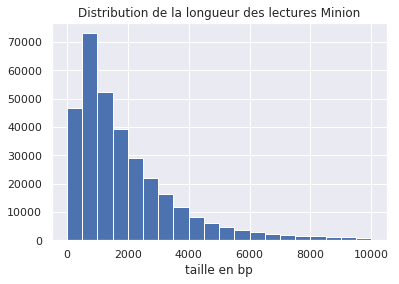

In [109]:
plt.hist(taille, range = (0,10000),bins=20)
plt.title("Distribution de la longueur des lectures Minion")
plt.xlabel("taille en bp")
plt.show()
#taille génome 3711100 et nombre de fragments : 172138 

### PACBIO

On sait que pour le pacbio, on prend les reads < 8000 bp et les grands fragments sont découpés en petits fragments

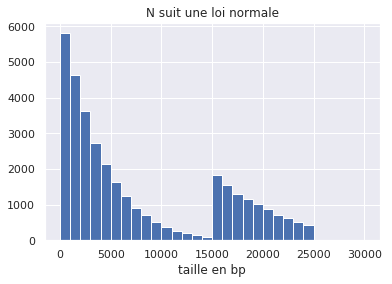

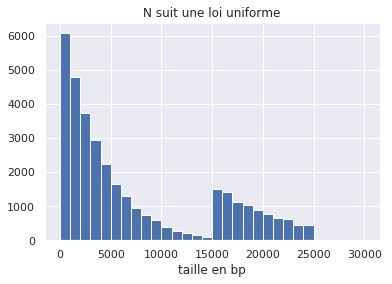

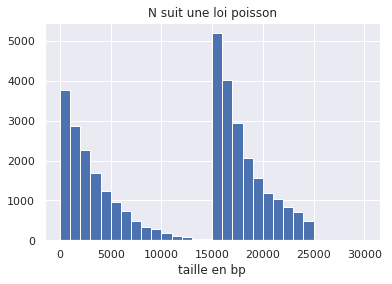

In [129]:
taille_genome =4000000
nbr_fragments = 35065
Mu = 600
Sigma = 10
Nmin = 500
Nmax = 600
Lambda = 1001.5024566650391

def poid(element, tout, maxi, mini):
    p = maxi - element 
    return p


for loi, parametres in [
    ('normale', (Mu, Sigma)),
    ('uniforme', (Nmin, Nmax)),
    ('poisson', Lambda)
]:
    fragments = list(chain.from_iterable(fracture([taille_genome] * 1000,loi, parametres)))
   
    
    
    fragments = [i  for i in fragments if i >= 15000]
    ok, ko = [], []
    for i in fragments:
        (ok if i < 25000 else ko).append(i)
    length = len(ko)
    
    for i in ko:
        ok.extend(get_parts(i,9))
        
          
    maxi, mini = max(ok), min(ok)
    sumi = sum(ok)
      
    poids = list(map(partial(poid, mini=mini, maxi=maxi, tout=ok), ok))
    s=sum(poids)
    #ok = choice(ok, 35065, p=poids/s, replace=False)
    ok = random.sample(ok, nbr_fragments)
    plt.hist(ok, range = (0,30000), bins=30)
    plt.xlabel('taille en bp')
    plt.title('N suit une loi %s' %loi)
    
    plt.show()
    



In [132]:
monFichier = open("../Documents/Donnees/DRR129657_subreads.fastq", "r") #pacbio
taille = []
f = []
norm = []

for line in monFichier:
    fields = line.strip().split()
    for idx, word in enumerate(fields):
        f.append(word)

for i, element in enumerate(f):
    if element.endswith("/1") and i + 1 < len(f):
        taille.append(len(f[i + 1]))

45370


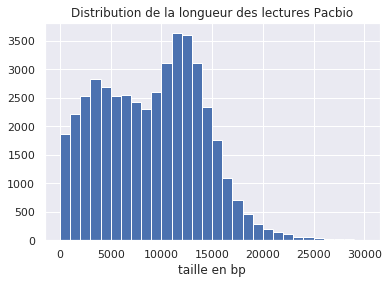

In [128]:
plt.hist(taille, range = (0,30000),bins=30)
plt.title("Distribution de la longueur des lectures Pacbio")
plt.xlabel("taille en bp")
print(len(taille))

In [135]:

f=open("don.txt",'w')
for l in taille:
    f.writelines(l)
    #f.write('\n') #(si besoin)
f.close()

TypeError: 'int' object is not iterable

# Théorie : on calcule les densités des lois composées

## Loi bêta - uniforme

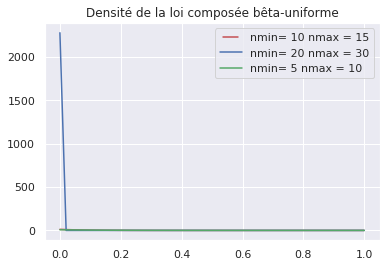

In [126]:
axes = plt.gca() 
x=np.linspace(0.00001,0.9999)
def f(x,a, b):
    return np.exp(-np.log(1-x))/(b-a)*((b*np.exp(b*np.log(1-x)) - a*np.exp(a*np.log(1-x)))/(np.log(1-x)) +
                                           (np.exp(a*np.log(1-x)) - np.exp(b*np.log(1-x)))/((np.log(1-x))**2))



plt.title('Densité de la loi composée bêta-uniforme')

line1, =plt.plot(x,f(x,10,15), 'r', label="nmin= 10 nmax = 15")
line2,=plt.plot(x,f(x,735,3945), 'b',label="nmin= 20 nmax = 30")
plt.plot(x,f(x,5,10), 'g',label="nmin= 5 nmax = 10")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})

plt.show()

## Loi bêta-poisson

On calcule la densité de la loi composée H de la loi bêta F et de poisson G.

$p_{H}(x) = \int_{0}^{+\infty} p_{F}(x|\theta) p_{G}(\theta)d\theta$

$p_{H}(x) = \int_{0}^{+\infty}n(1-x)^{n-1}\frac{\lambda^{n}e^{-\lambda}}{n!}dn$

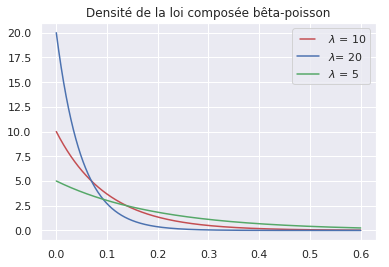

In [117]:
x=np.linspace(0,0.6,1000)
l=100
from matplotlib.legend_handler import HandlerLine2D
def f(x, l):
    return (l*np.exp(-l*x))

plt.title('Densité de la loi composée bêta-poisson')
line1, =plt.plot(x,f(x,10), 'r', label="$\lambda$ = 10")
line2,=plt.plot(x,f(x,20), 'b',label="$\lambda$= 20")
plt.plot(x,f(x,5), 'g',label="$\lambda$ = 5")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=4)})

plt.show()

Avec R, en utilisant le package Compounding : densité de la loi bêta-poisson.

Paramètres de la loi poisson : $\lambda = 250$

Et paramètres de la loi bêta : $\alpha = 1$ et $\beta = 250$


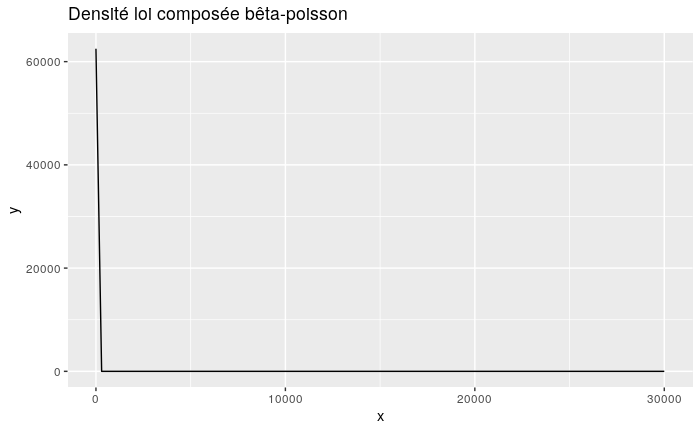

D'après R on obtient que la moyenne de cette loi composée est égale à : 1.605623e-05

Et la variance est égale à : 5.190403e-10

Et pour la loi bêta de paramètres : $\alpha = 1$ et $\beta = 60 000$

Sa moyenne vaut : 1.666639e-05

Et sa variance vaut : 2.777593e-10

In [13]:
def function(f, x_min, x_max, nb_x, n, comparer=False):
    """Prend comme paramètre une fonction densité, qui devra prendre en compte un ensemble x
    comme paramètre et retourne `n` nombres suivant la loi de f (tracer l'histogramme de présence
    de cette valeur nous donnera une approximation de la courbe de f)
    """
    
    pas = (x_max - x_min) / (nb_x * 2)
    # On prend en compte un décalage, car l'intégrale sera sur un intervalle, par conséquent il est plus judicieux
    #    de l'associer au milieu des segments de l'axe
    x = np.linspace(x_min + pas, x_max - pas, nb_x)
    y = f(x)

    # Somme utilisée pour normaliser la somme des probabilités : aire du rectangle/aire totale de tous les rectangles
    S = sum(y)
    c = choice(x, n, p=y/S, replace=True)
    
    plt.hist(c,bins=20)
    plt.title("Distribution des valeurs générées suivant la loi de f")
    plt.show()
        
    if comparer:
        compare(f, x, y)
    
    return c



In [14]:
def compare(f, x, y):
    """
    affiche la courbe f avec les rectangles
    f : densité
    x : abscisses
    y = f(x)
    """
    pas = x[1] - x[0]
    demi_pas = pas / 2
    
    # Ajout des deux extremitées de la courbe
    x_l = list(x)
    x_2 = np.array([x_l[0] - demi_pas] + x_l + [x_l[-1] + demi_pas])
    plt.plot(x_2, f(x_2), "bo-")
    
    for i in range(len(y)):
        x_0, x_1 = x[i] - demi_pas,x[i] + demi_pas 
        x_rect = [x_0,   x_0,  x_1,  x_1, x_0] # abscisses des sommets
        y_rect = [0   , y[i], y[i],    0,   0] # ordonnees des sommets
        plt.plot(x_rect, y_rect,"r")
    plt.show()

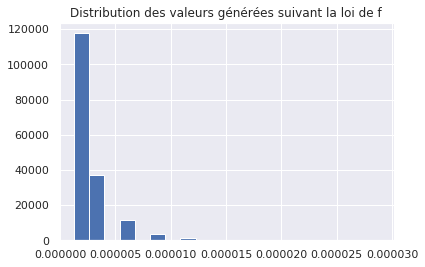

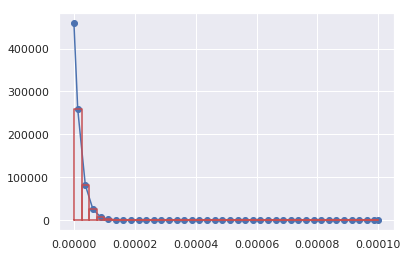

array([3.75e-06, 1.25e-06, 6.25e-06, ..., 1.25e-06, 3.75e-06, 1.25e-06])

In [57]:
nombre_intervalle = 40
nombre_valeurs = 172138
x_min = 0
x_max = 0.0001
l = 460000
def f_densite(x):
    return (l*np.exp(-l*x))

function(f_densite, x_min, x_max, nombre_intervalle, nombre_valeurs, comparer=True)


In [118]:
from scipy.integrate import simps
def f(n):
    mu = 100
    sigma = 1
    #x = np.linspace(0,0.99,10)
    return (np.exp(-((n-mu)**2)/2*sigma)*n*(1-p)**(n-1))/((2*np.pi)**(1/2))

n = np.linspace(1,100,10)
y = f(n)
print(n)
print(y)
# using Trapezoidal rule:

area = np.trapz(y,n)
print (area)

# using Simpson's rule:

area = simps(y,n)
print (area)

NameError: name 'p' is not defined

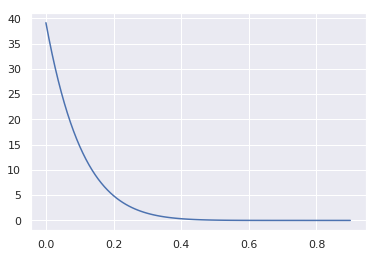

In [8]:
def carre(y):
    mu = 10
    sigma = 1
    x = np.linspace(0,0.9,100)
    
    return (np.exp(-((y-mu)**2)/2*sigma)*y*(1-x)**(y-1))/((2*np.pi)**(1/2))

def trapeze(f, a, b, n) : 
    if a > b :
        return -trapeze(f, b, a, n) 
    pas = (b-a) / float(n) 
    res = (f(a)+f(b)) / 2. 
    for k in range(1,n) : 
        res += f(a + k*pas)
    res *= pas 
    return res
x = np.linspace(0,0.9,100)
trapeze(carre, 0.32, 1000, 100)
plt.plot(x, trapeze(carre, 0.32, 1000, 100) )

In [68]:
import numpy as np
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * np.exp(-b * x) + c
xdata = np.linspace(0, 4, 50)
y = func(xdata, 2.5, 1.3, 0.5)
ydata = y + 0.2 * np.random.normal(size=len(xdata))
popt, pcov = curve_fit(func, xdata, ydata)
popt, pcov = curve_fit(func, xdata, ydata, bounds=(0, [3., 2., 1.]))
print(popt)
print(pcov)

[2.53058544 1.20800946 0.46709761]
[[ 0.00985003  0.00344892 -0.00068392]
 [ 0.00344892  0.01152686  0.00394564]
 [-0.00068392  0.00394564  0.00233583]]


In [95]:
import numpy as np
from scipy.optimize import curve_fit
def func(x,l):
    return (l*np.exp(-l*x))

xdata = np.linspace(0, 0.02, 172138)
y = func(xdata,2)
ydata = norm
popt, pcov = curve_fit(func, xdata, ydata)
popt, pcov = curve_fit(func, xdata, ydata, bounds=(0, 70000))
print(popt)
print(pcov)

[0.0014685]
[[3.14259181e-11]]


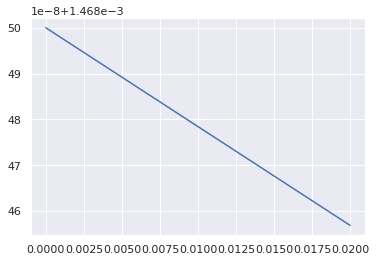

In [97]:
#plt.hist(norm)
plt.plot(xdata, func(xdata, 0.0014685))



In [146]:
def func(x,l):
    return (l*np.exp(-l*x))

ZeroDivisionError: integer division or modulo by zero

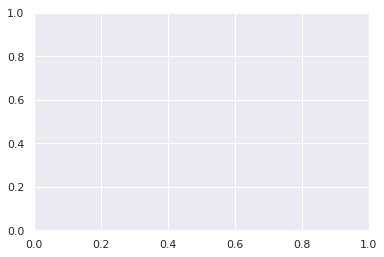

In [148]:
xdata = sorted(norm)
ydata = []
l = 1
for i in xdata:
    ydata.append(func(xdata,l))


plt.plot(xdata, ydata, 'b-', label='data')
popt, pcov = curve_fit(func, xdata, ydata)
print(popt)

plt.plot(xdata, func(xdata, *popt), 'r-')

popt, pcov = curve_fit(func, xdata, ydata)
popt
print(popt)
plt.plot(xdata, func(xdata, *popt), 'g--')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

(array([1.33359e+05, 1.82980e+04, 8.42800e+03, 4.71600e+03, 2.87500e+03,
        1.83500e+03, 1.08300e+03, 6.38000e+02, 3.86000e+02, 2.39000e+02,
        1.29000e+02, 6.90000e+01, 4.10000e+01, 2.40000e+01, 8.00000e+00,
        3.00000e+00, 4.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00]),
 array([3.77246638e-06, 1.70887338e-03, 3.41397429e-03, 5.11907521e-03,
        6.82417612e-03, 8.52927703e-03, 1.02343779e-02, 1.19394789e-02,
        1.36445798e-02, 1.53496807e-02, 1.70547816e-02, 1.87598825e-02,
        2.04649834e-02, 2.21700843e-02, 2.38751853e-02, 2.55802862e-02,
        2.72853871e-02, 2.89904880e-02, 3.06955889e-02, 3.24006898e-02,
        3.41057907e-02]),
 <a list of 20 Patch objects>)

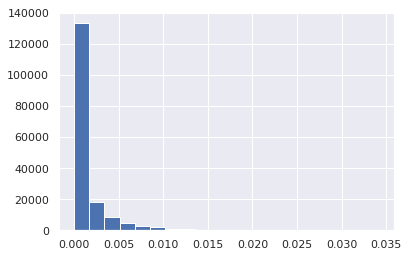

In [163]:
ynorm = []
plt.hist(norm, bins = 20)
    

[[Model]]
    Model(func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 20
    # data points      = 172138
    # variables        = 1
    chi-square         = 0.93113617
    reduced chi-square = 5.4093e-06
    Akaike info crit   = -2087584.64
    Bayesian info crit = -2087574.59
[[Variables]]
    l:  0.00146848 +/- 5.6057e-06 (0.38%) (init = 2000)



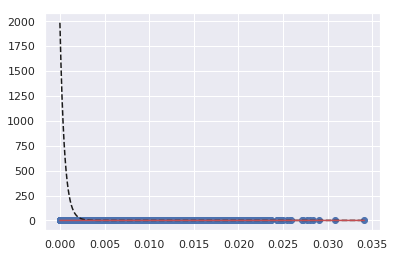

In [162]:
from numpy import sqrt, pi, exp, linspace, loadtxt
from lmfit import  Model

import matplotlib.pyplot as plt


y = (norm)
x = sorted(norm)


gmod = Model(func)
result = gmod.fit(y,x=x, l=2000)

print(result.fit_report())

plt.plot(x, y,         'bo')
plt.plot(x, result.init_fit, 'k--')
plt.plot(x, result.best_fit, 'r-')
plt.show()

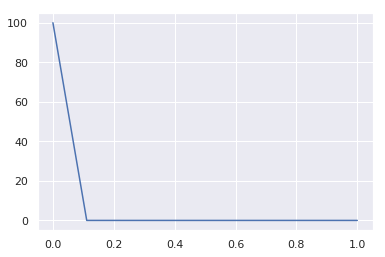

In [186]:
def func(x):
    l=100
    return (l*np.exp(-l*x))
x = np.linspace(0,1,10)
plt.plot(x, func(x))

(array([525., 229., 120.,  51.,  33.,  18.,   7.,   1.,   0.,   3.]),
 array([1.94023237e-05, 6.61852443e-03, 1.32176465e-02, 1.98167687e-02,
        2.64158908e-02, 3.30150129e-02, 3.96141350e-02, 4.62132571e-02,
        5.28123792e-02, 5.94115013e-02, 6.60106234e-02]),
 <a list of 10 Patch objects>)

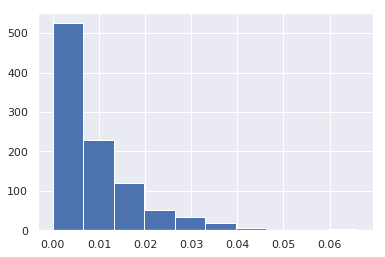

In [189]:
def randomvariate(pdf,n=1000,xmin=0,xmax=1): 
    x=np.linspace(xmin,xmax,10)  
    y=pdf(x)  
    pmin=0.  
    pmax=y.max()  
   
  # Counters  
    naccept=0  
    ntrial=0  
   
  # Keeps generating numbers until we achieve the desired n  
    ran=[] # output list of random numbers  
    while naccept<n:  
        x=np.random.uniform(xmin,xmax) # x'  
        y=np.random.uniform(pmin,pmax) # y'  
   
        if y<pdf(x):  
            ran.append(x)  
            naccept=naccept+1  
        ntrial=ntrial+1  
    
    ran=np.asarray(ran)  
    
    return ran
ran = randomvariate(func,987,0,1)
plt.hist(ran)